<a href="https://colab.research.google.com/github/salv0304/Machine_Learning/blob/main/CMS_Jets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CERN Proton Collision Dataset

The data contains 21726 observations with 17 attributes.

Classification problem with different models to predict the number of jets produced by an event

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn.functional as F

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_excercises/CMS_Jet/MultiJetRun2010B.csv.zip')
df.head()

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,148029,388,302318745,215.553,0.031977,136.7100,-109.893,-54.03420,-58.9032,142.1790,70.0254,41.12250,-116.5130,203.666,18.31100,2,0
1,148029,388,302323641,155.437,0.042157,83.3865,81.150,6.88361,-12.9688,73.9025,-72.2472,11.88350,3.0899,154.659,14.77470,2,0
2,148029,388,302336217,400.563,0.026938,253.1840,139.902,102.64000,-101.9350,535.5510,-110.3790,-89.09290,-516.1790,343.280,25.22110,3,0
3,148029,388,302382289,286.245,0.094192,175.4860,-156.024,-62.95350,-47.7434,112.8510,89.0843,3.45025,67.9007,257.397,46.02880,2,0
4,148029,388,302403873,204.514,0.018804,833.7950,100.410,-16.65900,-827.4980,445.6120,-91.1991,15.55830,-390.1440,269.492,8.11345,3,0


In [3]:
X = df.drop(columns=['nJets'])
y = df['nJets']

#Change the values 5, 6, and 7 to a unique value '5+'
y = y.replace([5,6,7],'5+')
y = y.astype(str)

print(X.shape)
print(y.shape)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(21726, 16)
(21726,)
nJets
2     14002
3      6204
4      1325
5+      195
Name: count, dtype: int64


## Knn classifier

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [5]:
# Make predictions
y_pred = knn.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

Accuracy: 0.59


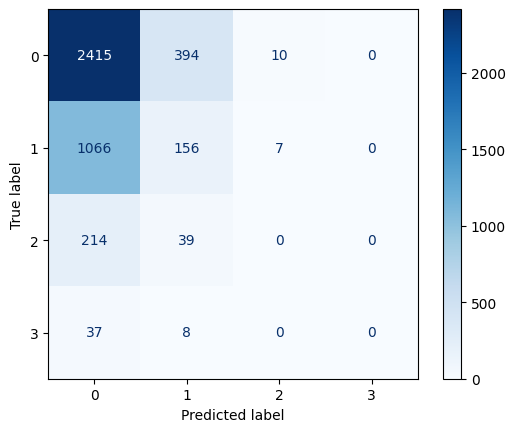

In [6]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())

###Model selection

We can try to improve the accuracy with the forward stepwise selection, selecting only those features that improves the accuracy. Reducing the number of features may give a better accuracy.

In [7]:
# Forward Stepwise Selection
forward_selector = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='forward',cv=5,scoring="accuracy")
forward_selector.fit(X_train, y_train)
best_forward_features = X_train.columns[forward_selector.get_support()]

In [8]:
print("Best features selected by Forward Selection:", list(best_forward_features))

Best features selected by Forward Selection: ['Run', 'MR', 'Rsq', 'E1', 'E2', 'HT', 'MET', 'nBJets']


In [9]:
X_fwd = df[best_forward_features]

X_fwd_train, X_fwd_test, y_fwd_train, y_fwd_test = train_test_split(X_fwd, y, test_size=0.2, random_state=42)

In [10]:
knn.fit(X_fwd_train, y_fwd_train)

# Make predictions
y_fwd_pred = knn.predict(X_fwd_test)

# Evaluate performance
accuracy = accuracy_score(y_fwd_test, y_fwd_pred)
print(f"Accuracy: {accuracy:.2f}")
#print("Classification Report:")
#print(classification_report(y_fwd_test, y_fwd_pred))

Accuracy: 0.69


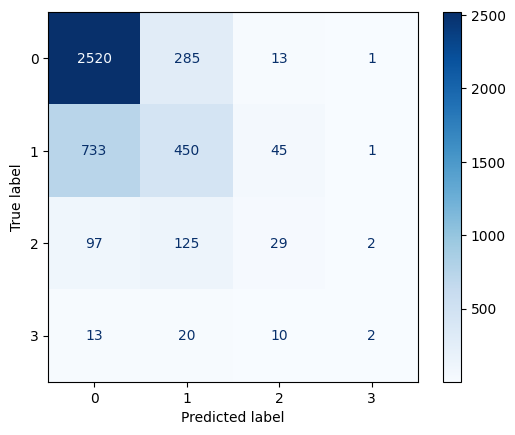

In [11]:
cm = confusion_matrix(y_fwd_test, y_fwd_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())

##Logistic regression

In [ ]:
X = df[['HT', 'Px2', 'Py2', 'Px1', 'Py1','E1', 'E2', 'MR']]
y = df['nJets']

#Change the values 5, 6, and 7 to a unique value '5+'
y = y.replace([5,6,7],'5+')
y = y.astype(str)

#Mapping
label_mapping = { '2': 0, '3': 1, '4': 2, '5+': 3}
y_numeric = [label_mapping[label] for label in y]

#Converting X and y
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y_numeric, dtype=torch.float32)

print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tensor([0., 0., 1.,  ..., 2., 0., 2.])


In [ ]:
def multinomial_logreg_inference(w, b, X):
    z = X @ w + b
    return torch.softmax(z, dim=1)

def cross_entropy_multiclass(Y, p):
    return F.cross_entropy(p, Y.long()) #Y must be a LongTensor

In [ ]:
#Training
STEPS = 8000
LR = 0.02
num_classes = 4  # Update with your actual number of classes (2, 3, 4, 5+)

#Initializing the parameters
w = torch.randn(X_train.shape[1], num_classes, requires_grad=True)
b = torch.randn(num_classes, requires_grad=True)

#Introducing SGD optimizer
optimizer = torch.optim.SGD([w,b], lr=LR)

#Defining lists for plotting accuracy / loss vs steps
steps = []
losses = []
accuracies = []


for step in range(STEPS):
    optimizer.zero_grad()

    #Computing the current values of w and b
    p = multinomial_logreg_inference(w, b, X_train)
    loss = cross_entropy_multiclass(y_train, p)

    #Compute the accuracy
    accuracy = (p.argmax(dim=1) == y_train.long()).float().mean()

    #Compute the gradient
    loss.backward()

    #Update the parameters
    optimizer.step()

    #Populating lists
    steps.append(step)
    losses.append(loss.item())
    accuracies.append(accuracy.item())

    #Diagnostic
    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

Step 0, Loss: 1.3647, Accuracy: 0.3785
Step 500, Loss: 1.2062, Accuracy: 0.5369
Step 1000, Loss: 1.1170, Accuracy: 0.6268
Step 1500, Loss: 1.1114, Accuracy: 0.6322
Step 2000, Loss: 1.1006, Accuracy: 0.6430
Step 2500, Loss: 1.1003, Accuracy: 0.6434
Step 3000, Loss: 1.1003, Accuracy: 0.6434
Step 3500, Loss: 1.1003, Accuracy: 0.6434
Step 4000, Loss: 1.1003, Accuracy: 0.6434
Step 4500, Loss: 1.1003, Accuracy: 0.6434
Step 5000, Loss: 1.1003, Accuracy: 0.6434
Step 5500, Loss: 1.1003, Accuracy: 0.6434
Step 6000, Loss: 1.1003, Accuracy: 0.6434
Step 6500, Loss: 1.1003, Accuracy: 0.6434
Step 7000, Loss: 1.1003, Accuracy: 0.6434
Step 7500, Loss: 1.1003, Accuracy: 0.6434


In [ ]:
p = multinomial_logreg_inference(w, b, X_test)
test_accuracy = (p.argmax(dim=1) == y_test.long()).float().mean()
print(test_accuracy)

tensor(0.6486)


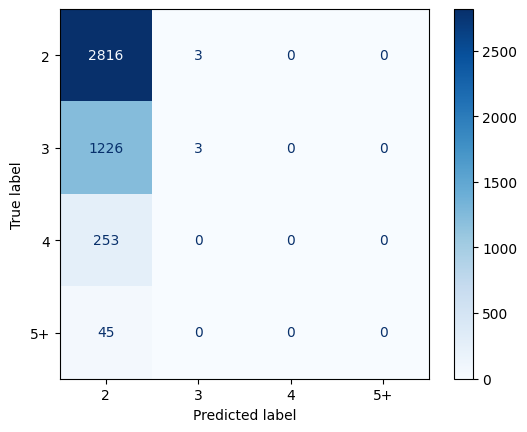

In [ ]:
# Convert tensor predictions to numpy array for confusion matrix
p = multinomial_logreg_inference(w, b, X_test)
y_pred = p.argmax(dim=1)


cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
label_mapping = {0: '2', 1: '3', 2: '4', 3: '5+'}
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())


#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
#plt.show()

## Tree

In [12]:
X = df.drop(columns=['nJets'])
y = df['nJets']

#Change the values 5, 6, and 7 to a unique value '5+'
y = y.replace([5,6,7],'5+')
y = y.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy_tree = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

Decision Tree Accuracy: 0.6905


In [13]:
tree_rules = export_text(clf, feature_names=list(X.columns))
print(tree_rules)

|--- HT <= 214.44
|   |--- HT <= 195.22
|   |   |--- HT <= 178.50
|   |   |   |--- E1 <= 67.58
|   |   |   |   |--- MR <= 184.33
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- MR >  184.33
|   |   |   |   |   |--- class: 3
|   |   |   |--- E1 >  67.58
|   |   |   |   |--- MR <= 123.61
|   |   |   |   |   |--- HT <= 144.79
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- HT >  144.79
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |--- MR >  123.61
|   |   |   |   |   |--- E2 <= 58.26
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- E2 >  58.26
|   |   |   |   |   |   |--- HT <= 168.08
|   |   |   |   |   |   |   |--- Py1 <= -102.94
|   |   |   |   |   |   |   |   |--- Px2 <= -25.22
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- Px2 >  -25.22
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- Py1 >  -102.94
|   |   |   |   |   |   |   |   |--- HT <= 165.11
|   |   |   |   | 

##Advanced Trees

In [14]:
#Bagging
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=200, random_state=42)
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)

In [15]:
#Random forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [21]:
#Boosting
gb = GradientBoostingClassifier(n_estimators=500, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [22]:
models = {
    "Decision Tree": y_pred,
    "Bagging": y_pred_bagging,
    "Random Forest": y_pred_rf,
    "Boosting (GradientBoostingClassifier)": y_pred_gb
}

In [23]:
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print(f"Bagging Accuracy: {accuracy_bagging:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")

Bagging Accuracy: 0.7890
Random Forest Accuracy: 0.7754
Gradient Boosting Accuracy: 0.8111


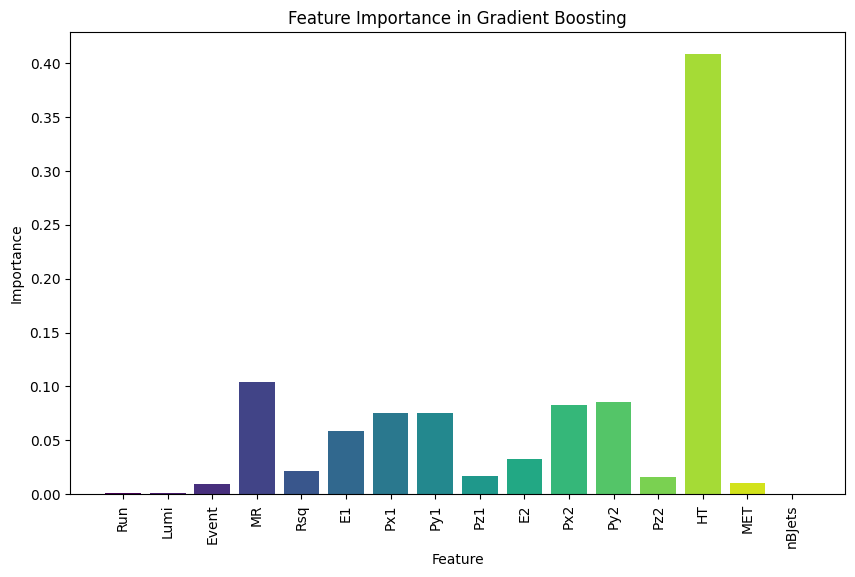

In [62]:
#Feature importance
importances = gb.feature_importances_

# Generate a range of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(X.columns)))

plt.figure(figsize=(10, 6))
plt.bar(X.columns, importances, color=colors)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Gradient Boosting")
plt.xticks(rotation=90)
plt.show()

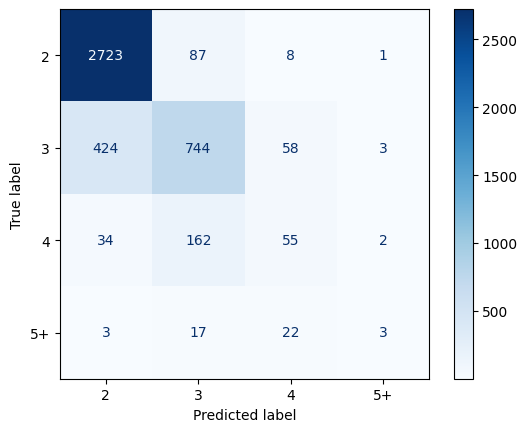

In [26]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
label_mapping = {0: '2', 1: '3', 2: '4', 3: '5+'}
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca())

In [38]:
run = X_test['Run'].copy() # will be used as run column of solution data frame
nJets = y_test.copy() # will be used as nJets column of solution data frame
solution = pd.DataFrame({'Run':run,'nJets': nJets,'nJets Predicted': y_pred_gb})
print(solution)

          Run nJets nJets Predicted
13474  149181     2               2
4954   147926     2               2
14301  149181     3               2
18423  149181     3               2
563    148029     2               2
...       ...   ...             ...
12587  149181     4               2
8129   147926     2               2
10476  149181     2               2
10455  149181     2               2
5687   147926     2               2

[4346 rows x 3 columns]


###ROC curve

In [49]:
print("Classi del modello:", gb.classes_)

Classi del modello: ['2' '3' '4' '5+']


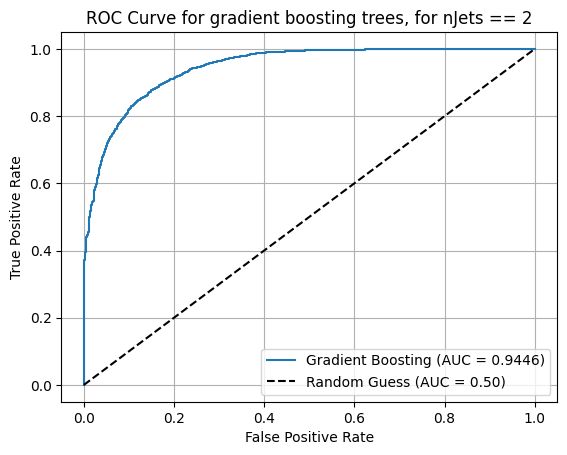

In [52]:
plt.figure()

#ROC curve
# Get probability scores (for ROC computation)
y_score = gb.predict_proba(X_test)

y_test_masked = (y_test == '2')
fpr, tpr, _ = roc_curve(y_test_masked, y_score[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {roc_auc:.4f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.50)")

# Customize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for gradient boosting trees, for nJets == 2")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()

Classes: ['2' '3' '4' '5+']


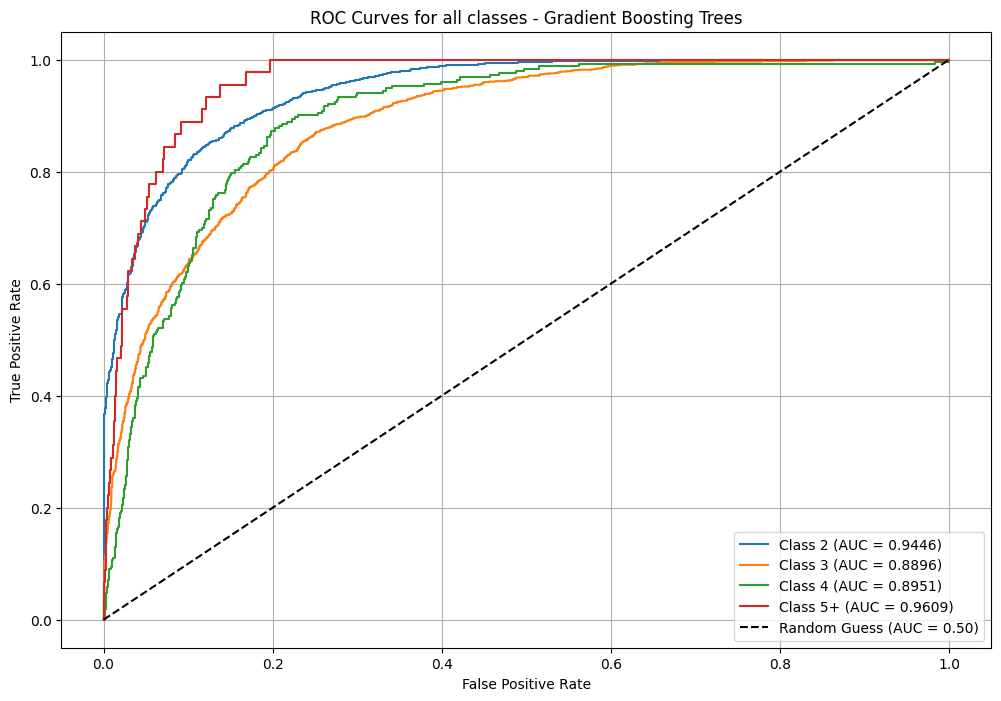

In [57]:
plt.figure(figsize=(12, 8))

y_score = gb.predict_proba(X_test)

print("Classes:", gb.classes_)

for i, class_name in enumerate(gb.classes_):
    y_test_masked = (y_test == class_name)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test_masked, y_score[:, i])
    roc_auc = auc(fpr, tpr)

    # Plott
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.4f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.50)")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for all classes - Gradient Boosting Trees")
plt.legend(loc="lower right")
plt.grid()

plt.show()

##Resume